# Exploring Time Series Data
Time series models are used in a wide range of applications, particularly for forecasting, which is the goal of this example, performed in four steps:

- Explore the characteristics of the time series data.
- Decompose the time series into trend, seasonal components, and remainder components. 
- Apply time series models.
- Forecast the production for a 12 month period. 

# Load and clean the data

The dataset is the **production** amount of several **diary products** in California, month by month, for 18 years.  
Our goal: forecast the next year production for one of those products: **milk**.

As usual, first we load the data into a Pandas dataframe.

In [1]:
import pandas as pd

X = pd.read_csv('../datasets/cadairydata.csv', index_col=0)
X.head()

,Year.Month,Month.Number,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price
1,1995.01,1,1995,Jan,4.370,51.595,2.112,0.9803
2,1995.02,2,1995,Feb,3.695,56.086,1.932,0.8924
3,1995.03,3,1995,Mar,4.538,68.453,2.162,0.8924
4,1995.04,4,1995,Apr,4.280,65.722,2.130,0.8967
5,1995.05,5,1995,May,4.470,73.730,2.227,0.8967


In [2]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 1 to 228
Data columns (total 8 columns):
Year.Month           228 non-null float64
Month.Number         228 non-null int64
Year                 228 non-null int64
Month                228 non-null object
Cotagecheese.Prod    228 non-null float64
Icecream.Prod        228 non-null float64
Milk.Prod            228 non-null float64
N.CA.Fat.Price       228 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 16.0+ KB


The first step is to have a Pandas date column which could be used as the time index.

## Add Pandas date-time column

The fastest way is to convert year and month to strings, then create a new Pandas *datetime* column that combine them.

In [3]:
X["Year"] = X["Year"].astype(str)

In [4]:
X["Month.Number"] = X["Month.Number"].astype(str)

In [5]:
X["YearMonth"] = pd.to_datetime(X["Year"] + X["Month.Number"], format="%Y%m") # new column

Now can drop the other date columns:

In [6]:
X.drop(["Year","Month", "Year.Month"], axis=1, inplace=True)

and I prefer to rename some of the other columns, for clarity:

In [7]:
X.rename(columns={'Cotagecheese.Prod':'CottageCheeseProd', 
                  'Icecream.Prod':'IceCreamProd',
                  'Milk.Prod':'MilkProd',
                  'N.CA.Fat.Price':'Price',
                  'Month.Number' : 'MonthNumber'},
          inplace=True)

In [8]:
X.head()

,MonthNumber,CottageCheeseProd,IceCreamProd,MilkProd,Price,YearMonth
1,1,4.370,51.595,2.112,0.9803,1995-01-01
2,2,3.695,56.086,1.932,0.8924,1995-02-01
3,3,4.538,68.453,2.162,0.8924,1995-03-01
4,4,4.280,65.722,2.130,0.8967,1995-04-01
5,5,4.470,73.730,2.227,0.8967,1995-05-01


In [9]:
X.tail()

,MonthNumber,CottageCheeseProd,IceCreamProd,MilkProd,Price,YearMonth
224,8,2.169,78.382,3.400,1.6273,2013-08-01
225,9,2.193,74.871,3.197,1.5519,2013-09-01
226,10,2.284,70.011,3.338,1.5566,2013-10-01
227,11,1.865,61.394,3.275,1.7537,2013-11-01
228,12,2.345,53.653,3.473,1.6747,2013-12-01


In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 1 to 228
Data columns (total 6 columns):
MonthNumber          228 non-null object
CottageCheeseProd    228 non-null float64
IceCreamProd         228 non-null float64
MilkProd             228 non-null float64
Price                228 non-null float64
YearMonth            228 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 12.5+ KB


Now, we can perform both arithmetic and logical operations on datetime objects ("YearMonth").  
As an example, here is how to select the last 12 months of dairy data:

In [11]:
X[X.YearMonth > "2012-12-01"]

,MonthNumber,CottageCheeseProd,IceCreamProd,MilkProd,Price,YearMonth
217,1,2.282,62.612,3.462,1.7744,2013-01-01
218,2,1.941,66.274,3.231,1.6224,2013-02-01
219,3,2.150,75.770,3.676,1.6968,2013-03-01
220,4,2.217,76.396,3.622,1.7444,2013-04-01
221,5,2.341,80.899,3.720,1.8552,2013-05-01
222,6,2.694,92.091,3.489,1.8314,2013-06-01
223,7,2.433,84.026,3.373,1.6923,2013-07-01
224,8,2.169,78.382,3.400,1.6273,2013-08-01
225,9,2.193,74.871,3.197,1.5519,2013-09-01
226,10,2.284,70.011,3.338,1.5566,2013-10-01


The Milk prpduction should be in million of pounds.

In [12]:
X.isnull().values.any() 

False

There are no NaNs. The dataset is ready to be explored.

# Explore the data
We concentrate now on the milk production (the *MilkProd* column).
## Create a Time Series Plot

First useful thing to do is always to plot the data:

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

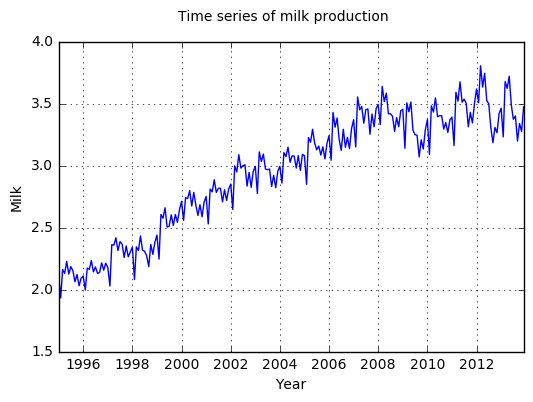

In [14]:
fig,ax = plt.subplots()
ax.plot(X.YearMonth, X.MilkProd)
ax.grid(True)
ax.set_xlabel("Year")
ax.set_ylabel("Milk")
fig.suptitle("Time series of milk production");

For most of the time period shown, the production of milk increased year over year. However, there is a decline in milk production starting in 2009 as a results of the recession. Also, notice that this time series exhibits a strong seasonal component with an annual cycle.

Since the time series has both a visible trend and a seasonality it is clearly a **non-stationary** series.

## Statistical Properties of the Time Series

Autocorrelation is a fundamental property of time series. The **Autocorrelation Function** or ACF provides information on the dependency of the time series values of previous values. 

In [15]:
import statsmodels.graphics.tsaplots as sm_pl

/Users/Massimo/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


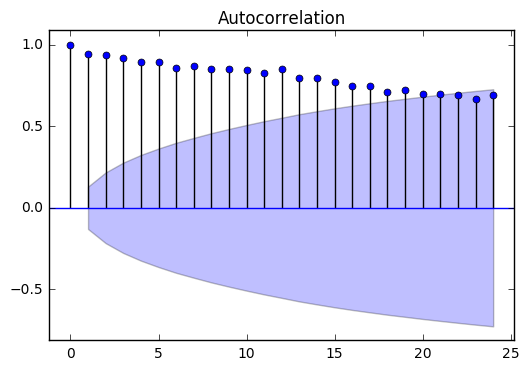

In [16]:
sm_pl.plot_acf(X.MilkProd, lags=24);

Lags are the months in this case.

Note that the values of the ACF at the various lags decays only slowly. This indicates **there is considerable auto correlation** between the time series values at the various lags, mostly likely from the trend.

Plotting a histogram provides information on the distribution of values of the time series. 

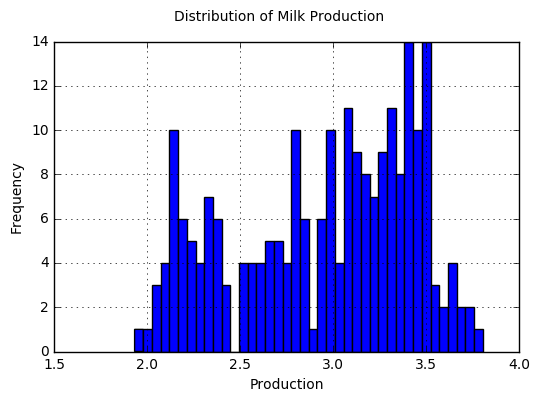

In [17]:
fig,ax = plt.subplots()
ax.hist(X.MilkProd, bins=40)
ax.grid(True)
ax.set_xlabel("Production")
ax.set_ylabel("Frequency")
fig.suptitle("Distribution of Milk Production");

The histogram of the full milk production time series shows considerable dispersion. Again this behavior is likely **the result of the trend**.

## Stationarity: are mean and standard deviation constant over time?

From the plot is pretty clear that there is trend and seasonality, therefore is not stationary. Anyway, can be checked.

In [18]:
rollingMean = X.MilkProd.rolling(window=12).mean()
rollingStd = X.MilkProd.rolling(window=12).std()

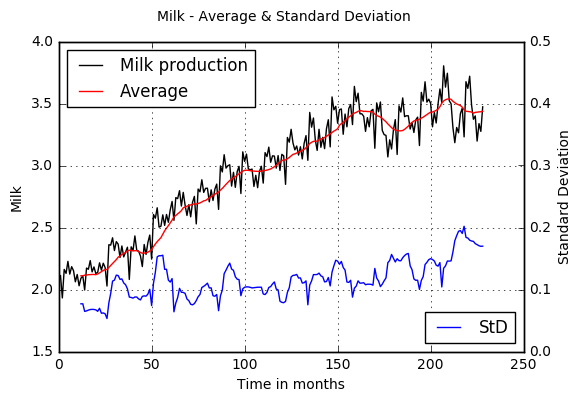

In [19]:
fig,ax1 = plt.subplots()
ax1.plot(X.MilkProd, color="black", label="Milk production")
ax1.plot(rollingMean, color="red", label="Average")
ax1.grid(True)
ax1.set_xlabel("Time in months")
ax1.set_ylabel("Milk")
ax1.legend(loc="upper left")

ax2 = ax1.twinx() # Create a twin Axes sharing the xaxis
ax2.plot(rollingStd, color = "blue", label = "StD")
ax2.set_ylabel("Standard Deviation")
ax2.legend(loc="lower right")
ax2.set_ylim(0,0.5)
fig.suptitle("Milk - Average & Standard Deviation");

The mean is clearly increasing over time (the production is rising) but also the standard deviation of milk production increased in the time frame.

# Decomposition of the Time Series

Time series are typically decomposed into three components: trend, seasonal, and the remainders, or residuals.  
Trend can be modeled by several methods. We will start by decomposing the time series using a simple moving average model. 

## Trend
The code in the cell below uses moving window method to compute the average of the time series over specified span, or order of the operator. As the moving window operator moves over the data, the average of the values in the windows is calculated. 

In [20]:
import numpy as np
def movingAverage(values, order):
    end = len(values)
    out = np.zeros(len(values))
    
    out[0] = values[1]
    for i in range(1,end):
        if (i - order <= 1):
            j = 1
        else:
            j += 1
        out[i] = sum(values[j-1:i]) / (i-j+1)
        
    return out

One of the best ways to make a series stationary on variance is through transforming the original series through log transform.  
We go back to our original data series and add a new column, the logarithm of the milk production:

In [21]:
X['LogMilk'] = pd.Series(np.log(X.MilkProd), index = X.index)

In [22]:
X.head()

,MonthNumber,CottageCheeseProd,IceCreamProd,MilkProd,Price,YearMonth,LogMilk
1,1,4.370,51.595,2.112,0.9803,1995-01-01,0.747635
2,2,3.695,56.086,1.932,0.8924,1995-02-01,0.658556
3,3,4.538,68.453,2.162,0.8924,1995-03-01,0.771034
4,4,4.280,65.722,2.130,0.8967,1995-04-01,0.756122
5,5,4.470,73.730,2.227,0.8967,1995-05-01,0.800655


Now we perform a 12 months moving average, to extract the trend:

In [23]:
trendM = movingAverage(X.LogMilk, 12) 

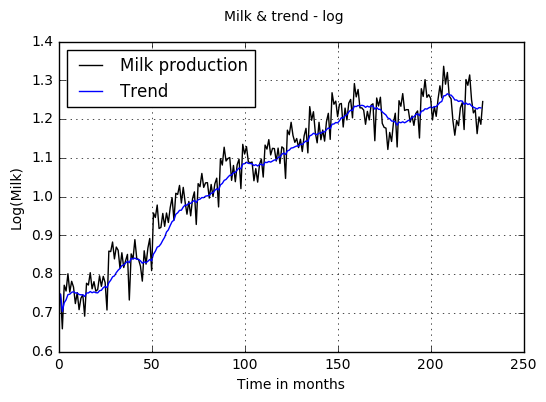

In [24]:
fig,ax = plt.subplots()
ax.plot(X.LogMilk, color="black", label="Milk production")
ax.plot(trendM, color="blue", label="Trend")

ax.grid(True)
ax.set_xlabel("Time in months")
ax.set_ylabel("Log(Milk)")
ax.legend(loc="upper left")


fig.suptitle("Milk & trend - log");

### Get the Trend with Lowess

Having tried a simple moving average decomposition, we will now use a lowess model to determine the trend. Lowess is a sophisticated non-linear regression.   

The *statsmodels* package includes a function to calculate the Lowess regression:

In [25]:
import statsmodels.nonparametric.smoothers_lowess as sm

trendL = sm.lowess(X.LogMilk, X.YearMonth, frac=0.25,return_sorted=False)

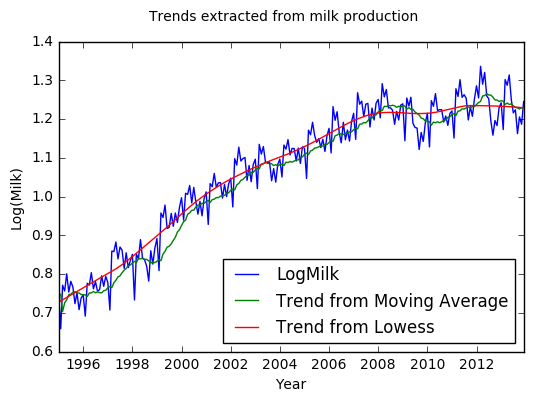

In [26]:
fig,ax = plt.subplots()
ax.plot(X.YearMonth, X.LogMilk)
ax.plot(X.YearMonth, trendM, label='Trend from Moving Average')
ax.plot(X.YearMonth, trendL, label="Trend from Lowess")
ax.set_xlabel("Year")
ax.set_ylabel("Log(Milk)")
ax.legend(loc="lower right")
fig.suptitle("Trends extracted from milk production");

The time series charts show the original time series along with the two trends. The trend from Lowess regression is a bit smoother than the one was obtained with the simple moving average decomposition. 

## Seasonality
Now we apply a linear regression on the Milk production using the months as variables to discover the seasonality.    

But first need to convert the months into categorical variables using the One Hot Encoder (OHE) approach.

In [27]:
monthsOHE = pd.get_dummies(X.MonthNumber)
monthsOHE.head()

,1,10,11,12,2,3,4,5,6,7,8,9
1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,0,0


The order doesn't matter in this case (October and November comes before February).

In [28]:
prodWithoutTrend = X.LogMilk - trendM # the difference

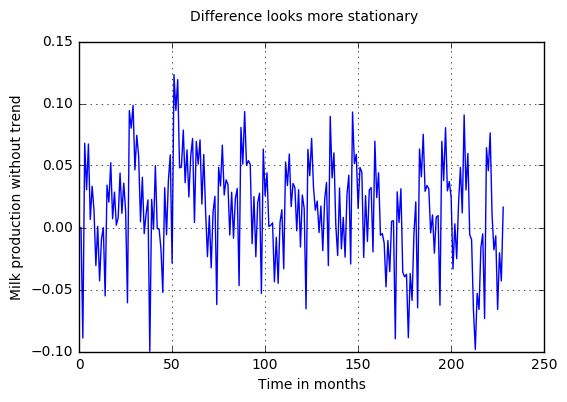

In [29]:
fig,ax = plt.subplots()
ax.plot(prodWithoutTrend)

ax.grid(True)
ax.set_xlabel("Time in months")
ax.set_ylabel("Milk production without trend")

fig.suptitle("Difference looks more stationary");

The milk production - when the trend is removed - seems more stationary, without any immediate pattern.  
We create now a temporary data frame to perform the regression:

In [30]:
    # a new tmp data frame for decomposition 
decX = pd.DataFrame({'LogMilkNoTrend': prodWithoutTrend}) 
decX = decX.join(monthsOHE)

In [31]:
decX.head()

,LogMilkNoTrend,1,10,11,12,2,3,4,5,6,7,8,9
1,0.000000,1,0,0,0,0,0,0,0,0,0,0,0
2,-0.089080,0,0,0,0,1,0,0,0,0,0,0,0
3,0.067938,0,0,0,0,0,1,0,0,0,0,0,0
4,0.030380,0,0,0,0,0,0,1,0,0,0,0,0
5,0.067319,0,0,0,0,0,0,0,1,0,0,0,0


The regression is applied to the production without trend:

In [32]:
from sklearn import linear_model
model = linear_model.LinearRegression(fit_intercept = False)

In [33]:
model.fit(monthsOHE, decX.LogMilkNoTrend)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

It's a model with 12 (one for each month, keep in mind that they are not in chronological order) variables:

In [34]:
model.coef_ 

array([ 0.02471208,  0.01099585, -0.02349834,  0.01714495, -0.04996016,
        0.06783954,  0.03872409,  0.06733682,  0.01530435,  0.02160618,
        0.01572798, -0.02670753])

Finally, we get the seasonality by predicting the value month by month:

In [35]:
seasonalM = model.predict(monthsOHE)

## Residuals

If we remove the seasonality from the difference between milk production and the trend, we will get the residuals or remainders:

In [36]:
remainderM = prodWithoutTrend - seasonalM

Finally, we put all together in a data fram that contains all decomposition elements: trend, seasonality and residuals

In [37]:
  # a data frame with all decompositions
decomposed = pd.DataFrame({'t': trendM, 's': seasonalM, 'r': remainderM})

In [38]:
decomposed.head() 

,r,s,t
1,-0.024712,0.024712,0.747635
2,-0.039119,-0.049960,0.747635
3,0.000099,0.067840,0.703096
4,-0.008344,0.038724,0.725742
5,-0.000018,0.067337,0.733337


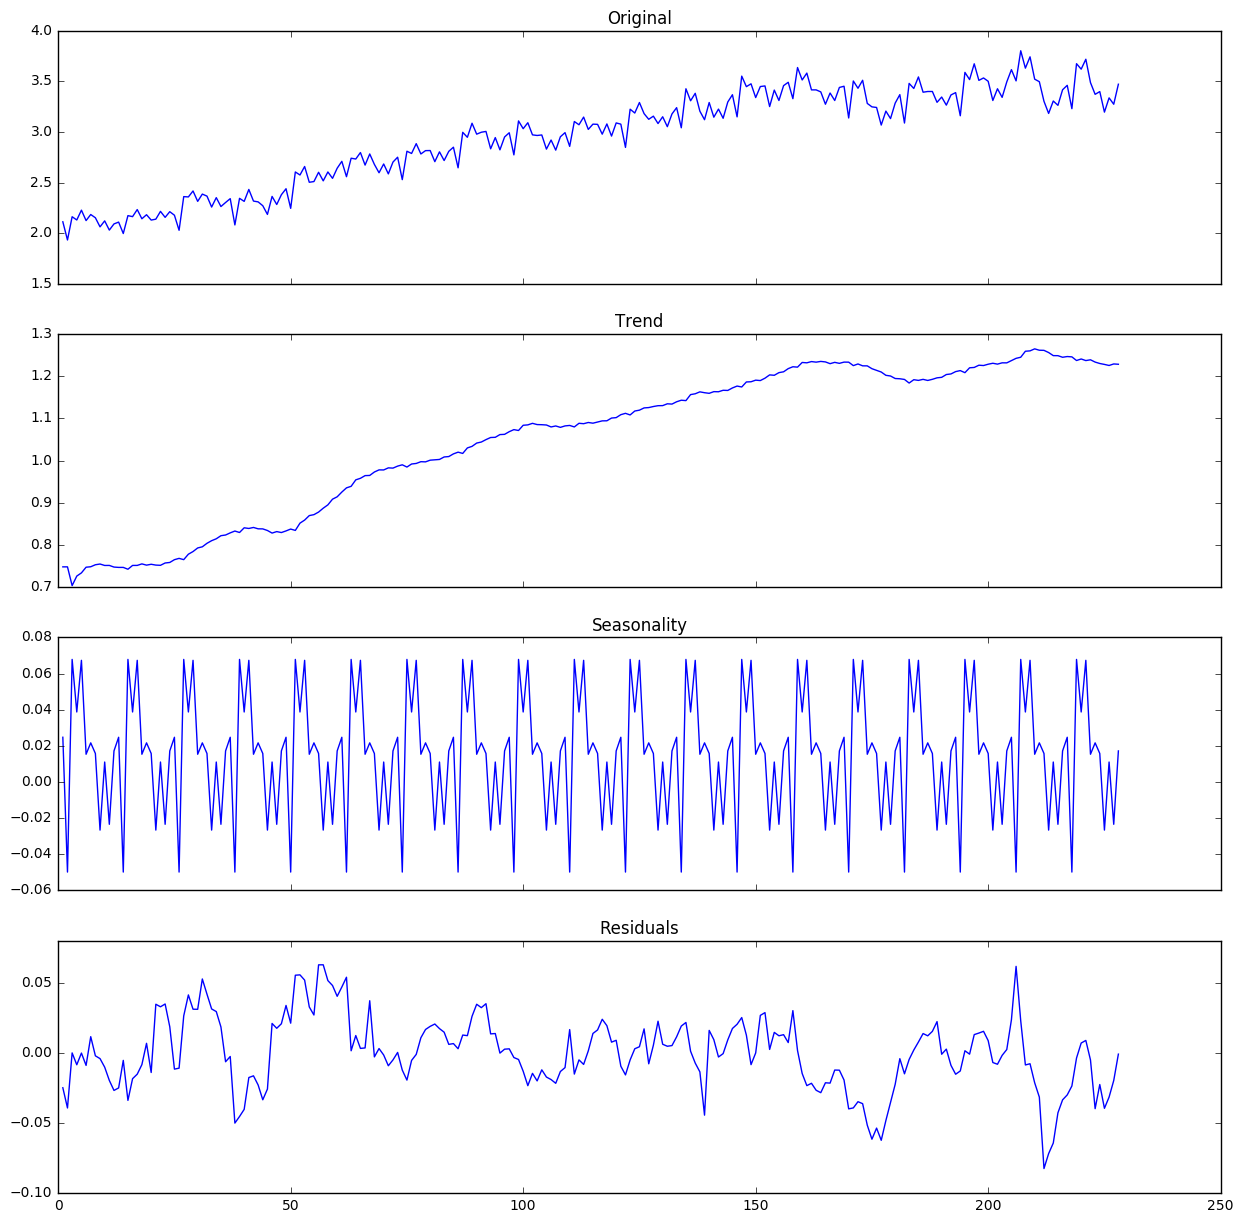

In [39]:
fig,ax = plt.subplots(4, sharex=True, figsize=(15,15))
ax[0].plot(X.MilkProd)
ax[0].set_title('Original')

ax[1].plot(decomposed.t)
ax[1].set_title('Trend')

ax[2].plot(decomposed.s)
ax[2].set_title('Seasonality')

ax[3].plot(decomposed.r)
ax[3].set_title('Residuals');

As we have seen, the trend is of an increasing milk production, beside the last months when it is stable; while there is a clear yearly seasonality.  
The remainders in an ideal situation are like white noise, i.e. every pattern has been removed and what is left is only the random variability.

## Decomposing using statsmodels
The *statsmodels* package has also a function to decompose a time series:

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

# need to pass the time series as array (values) because of error
# in statsmodels, should be fixed in next version 0.9
decomposition = seasonal_decompose(X.MilkProd.values, freq=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

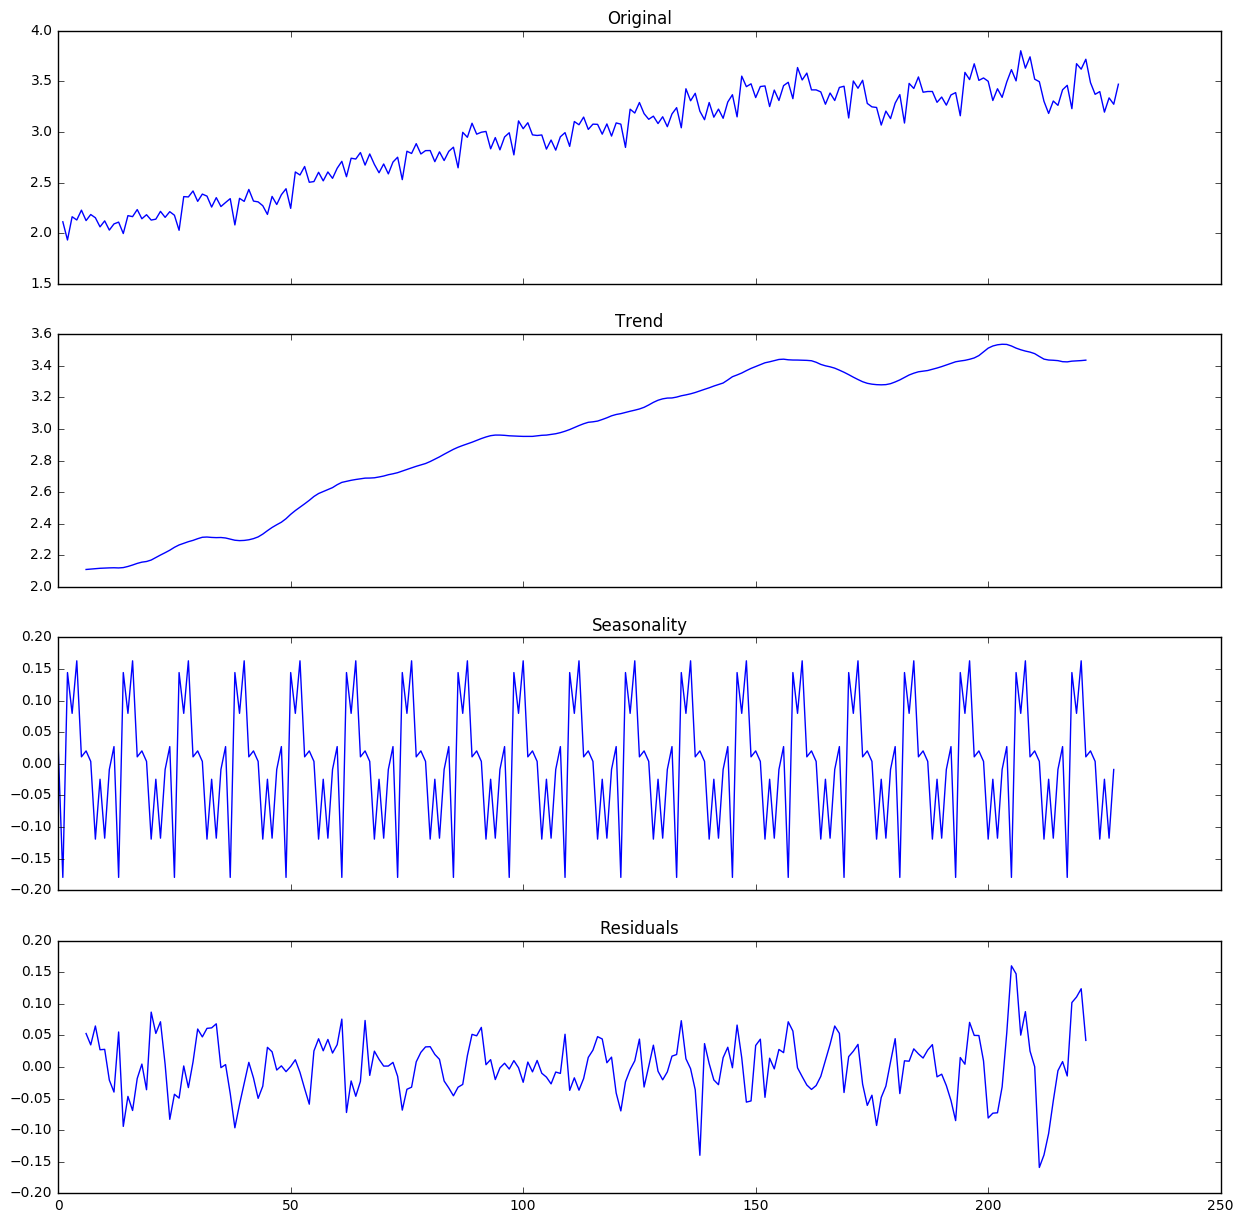

In [41]:
fig,ax = plt.subplots(4, sharex=True, figsize=(15,15))
ax[0].plot(X.MilkProd)
ax[0].set_title('Original')

ax[1].plot(trend)
ax[1].set_title('Trend')

ax[2].plot(seasonal)
ax[2].set_title('Seasonality')

ax[3].plot(residual)
ax[3].set_title('Residuals');

You can see the trend and seasonal components clearly separated in the above plots. The remainder plot looks fairly random, as expected. 

## Is now stationary?
The question remains, is the remainder from this decomposition stationary? To find out, we plot its ACF:

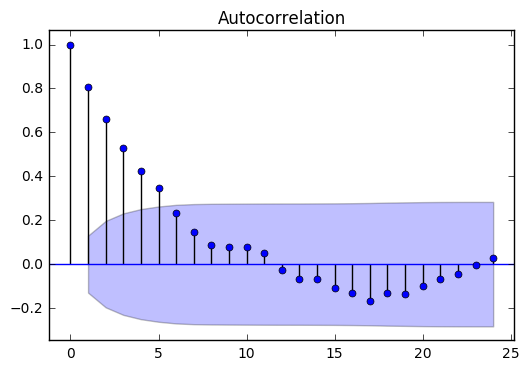

In [42]:
sm_pl.plot_acf(decomposed.r, lags=24);

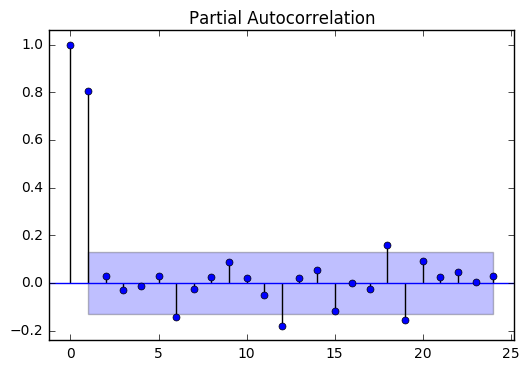

In [43]:
sm_pl.plot_pacf(decomposed.r, lags=24);

The ACF has at least 5 significant lag values, indicating the remainder is NOT, in fact, stationary.  
Compared to the behavior of the ACF for the simple moving average decomposition, the behavior of the remainder is improved.  

Now we plot the histogram of the remainder:

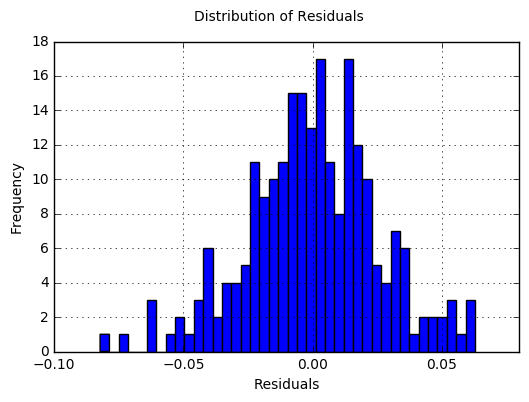

In [44]:
fig,ax = plt.subplots()
ax.hist(decomposed.r, bins=40)
ax.grid(True)
ax.set_xlabel("Residuals")
ax.set_ylabel("Frequency")
fig.suptitle("Distribution of Residuals");

The distribution of the remainder values is much closer to a Normal distribution than for the original time series we created earlier. This result, combined with the ACF plot, indicates that the decomposition is effective.  

We can further investigate the remainder (non-seasonal residual) component by making a box plot by month of the year:

In [45]:
remaindersByMonth = pd.DataFrame({'resid': decomposed.r, 'month': X["MonthNumber"]})

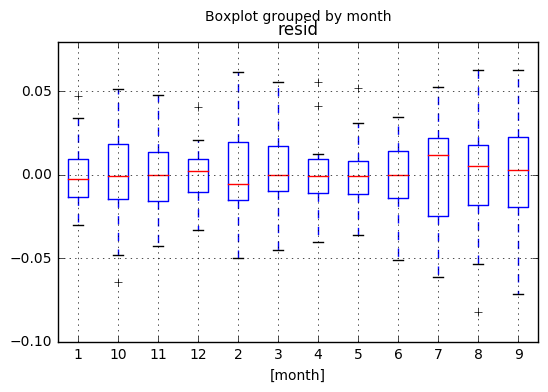

In [46]:
remaindersByMonth.boxplot(by='month');

The remainder component shows only limited variation from month to month. The differences are within the interquartile range, indicating that the seasonal model is a reasonably good fit.


# Moving Average Models

Now that we have explored the decomposition of the time series we will now construct and test Autoregressive Moving Average (ARMA) models for the remainder of the time series.  
We will create and test these models in three steps, first creating a moving average (MA) model, then creating an autoregressive (AR) model and finally an autoregressive moving average (ARMA) model. 

The ACF of the remainder from the decomposition of the milk production time series had at least 5 significant lag values. As an inital model, we therefore now create an MA model of order 5 and examine the model summary. 

In [47]:
from statsmodels.tsa.arima_model import ARIMA

In [48]:
modelMA5 = ARIMA(decomposed.r.values, order=(0,0,5))
resultsMA5 = modelMA5.fit(disp=0) # disp: do not display covergence info
resultsMA5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  228
Model:                     ARMA(0, 5)   Log Likelihood                 629.357
Method:                       css-mle   S.D. of innovations              0.015
Date:                Sat, 23 Jun 2018   AIC                          -1244.713
Time:                        13:58:41   BIC                          -1220.708
Sample:                             0   HQIC                         -1235.028
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.083e-05      0.003     -0.018      0.985      -0.007       0.006
ma.L1.y        0.7585      0.074     10.264      0.000       0.614       0.903
ma.L2.y        0.6238      0.086      7.278      0.000       0.456       0.792
ma.L3.y        0.4338      0.070      6.205      0.000       0.297       0.571
ma.L4.y        0.2543      0.073      3.488      0.001       0.111       0.397
ma.L5.y        0.2421      0.077      3.139      0.002       0.091       0.393
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.2767           -0.0000j            1.2767           -0.5000
MA.2           -0.5637           -1.1634j            1.2927           -0.3218
MA.3           -0.5637           +1.1634j            1.2927            0.3218
MA.4            0.6769           -1.2156j            1.3913           -0.1691
MA.5            0.6769           +1.2156j            1.3913            0.1691
-----------------------------------------------------------------------------
"""

Examining the values of the model coefficients and their standard errors (SE), we notice that the SE of the last two  coefficients is the same order than the value of the coefficient itself. This may indicate that the value of this coefficient is poorly determined and could likely be set to zero.  
The foregoing result indicates that the order of the MA model could be reduced. Generally, the order of an MA model is reduced in unit steps until all the coefficients appear to be significant.  
We try with 3 coefficients and examine the model summary.

In [49]:
modelMA3 = ARIMA(decomposed.r.values, order=(0,0,3))
resultsMA3 = modelMA3.fit(disp=0) # disp: do not display covergence info
resultsMA3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  228
Model:                     ARMA(0, 3)   Log Likelihood                 623.018
Method:                       css-mle   S.D. of innovations              0.016
Date:                Sat, 23 Jun 2018   AIC                          -1236.036
Time:                        13:58:41   BIC                          -1218.889
Sample:                             0   HQIC                         -1229.118
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.526e-05      0.003     -0.009      0.993      -0.006       0.006
ma.L1.y        0.8000      0.063     12.608      0.000       0.676       0.924
ma.L2.y        0.6155      0.061     10.074      0.000       0.496       0.735
ma.L3.y        0.3563      0.065      5.459      0.000       0.228       0.484
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.1203           -1.3687j            1.3739           -0.2640
MA.2           -0.1203           +1.3687j            1.3739            0.2640
MA.3           -1.4868           -0.0000j            1.4868           -0.5000
-----------------------------------------------------------------------------
"""

The AIC is slightly lower and the standard error compared to the magnitude of the coefficients is also slightly improved; indicates that the order of the model is more reasonable but probably not yet perfect.
To test how well this model fits the data, and results in a stationary result, we plot the ACF of the residuals of the MA(3) model:

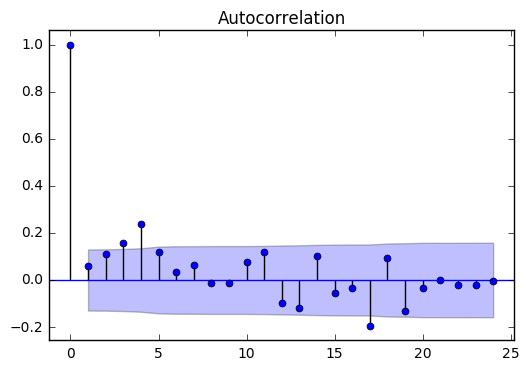

In [50]:
sm_pl.plot_acf(resultsMA3.resid, lags=24);

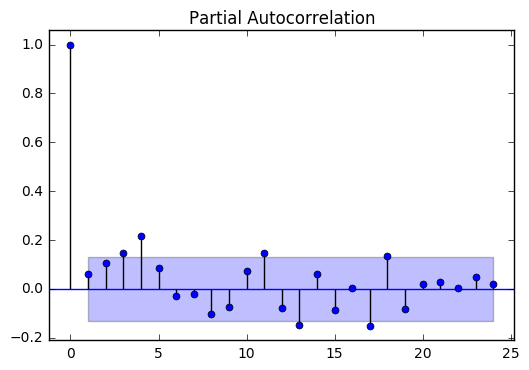

In [51]:
sm_pl.plot_pacf(resultsMA3.resid, lags=24);

## Autoregressive Models

Next, we  test an autoregressive model. The PACF of the reminder indicates that an AR model might not be the best choice. None the less, a low order AR model might fit these data. 

In general, AR orders will tend to present themselves by a sharp cutoff in the PACF plot and a slow trending or sinusoidal degradation in the ACF plot. The opposite is usually true for MA orders.

In [52]:
modelAR2 = ARIMA(decomposed.r.values, order=(2,0,0))
resultsAR2 = modelAR2.fit(disp=0) # disp: do not display covergence info
resultsAR2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  228
Model:                     ARMA(2, 0)   Log Likelihood                 632.334
Method:                       css-mle   S.D. of innovations              0.015
Date:                Sat, 23 Jun 2018   AIC                          -1256.668
Time:                        13:58:42   BIC                          -1242.951
Sample:                             0   HQIC                         -1251.133
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.005     -0.099      0.921      -0.011       0.010
ar.L1.y        0.7742      0.066     11.709      0.000       0.645       0.904
ar.L2.y        0.0389      0.066      0.584      0.560      -0.091       0.169
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2173           +0.0000j            1.2173            0.0000
AR.2          -21.1420           +0.0000j           21.1420            0.5000
-----------------------------------------------------------------------------
"""

The AIC value is the worst among the models tried.  
Examining the values of the coefficients and their standard errors, we note that the standard error of the second coefficient is actually bigger than the coefficient. Clearly, the AR(2) model is over parameterized. 

Next, we  try an AR(1) model.

In [53]:
modelAR1 = ARIMA(decomposed.r.values, order=(1,0,0))
resultsAR1 = modelAR1.fit(disp=0) # disp: do not display covergence info
resultsAR1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  228
Model:                     ARMA(1, 0)   Log Likelihood                 632.163
Method:                       css-mle   S.D. of innovations              0.015
Date:                Sat, 23 Jun 2018   AIC                          -1258.327
Time:                        13:58:42   BIC                          -1248.039
Sample:                             0   HQIC                         -1254.176
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.005     -0.088      0.930      -0.010       0.009
ar.L1.y        0.8055      0.039     20.777      0.000       0.729       0.881
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2415           +0.0000j            1.2415            0.0000
-----------------------------------------------------------------------------
"""

The standard error of the AR(1) model is an order of magnitude less than the value of the coefficient, which is promising.

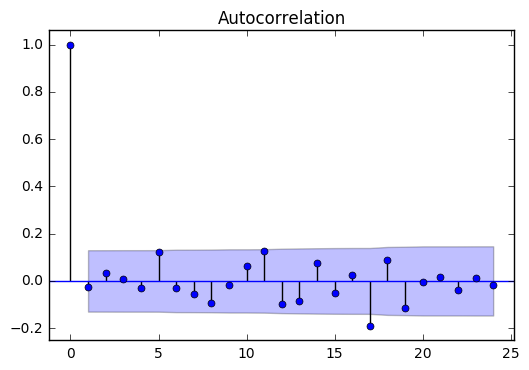

In [54]:
sm_pl.plot_acf(resultsAR1.resid, lags=24);

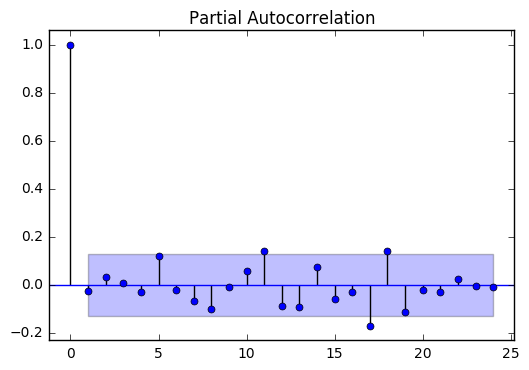

In [55]:
sm_pl.plot_pacf(resultsAR1.resid, lags=24);

Note that only the 0 lag of the ACF is significant and that there are no significant lags for the PACF. These observations indicate that the AR(1) model is a good fit. Compare these results to those of the MA(3) model, noting that they are nearly identical. Either the MA(3) or AR(1) model could be a good choice for these data.

## Autoregressive Moving Average (ARMA) Models
We have found that both MA(3) and AR(1) models are possibly good fits to the remainder series.  
We will now investigate the use of autoregressive Integrated moving average (ARIMA) models on the remainder series, a combination of both MA and AR models.  
As a starting point we try an ARIMA(1,3) model.

In [56]:
modelARMA = ARIMA(decomposed.r.values, order=(1,0,3))
resultsARMA = modelARMA.fit(disp=0) # disp: do not display covergence info
resultsARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  228
Model:                     ARMA(1, 3)   Log Likelihood                 632.544
Method:                       css-mle   S.D. of innovations              0.015
Date:                Sat, 23 Jun 2018   AIC                          -1253.087
Time:                        13:58:43   BIC                          -1232.511
Sample:                             0   HQIC                         -1244.785
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.005     -0.092      0.927      -0.010       0.009
ar.L1.y        0.8033      0.069     11.705      0.000       0.669       0.938
ma.L1.y       -0.0279      0.097     -0.287      0.774      -0.218       0.163
ma.L2.y        0.0548      0.084      0.649      0.517      -0.111       0.220
ma.L3.y       -0.0116      0.081     -0.144      0.886      -0.170       0.147
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2449           +0.0000j            1.2449            0.0000
MA.1           -0.8558           -3.5578j            3.6593           -0.2876
MA.2           -0.8558           +3.5578j            3.6593            0.2876
MA.3            6.4212           -0.0000j            6.4212           -0.0000
-----------------------------------------------------------------------------
"""

In each case, the standard error is of the same order of magnitude as the value of the coefficient, indicating this model is a poor fit to the data.

### Automatic search for the best ARIMA parameters

There are many guidelines and best practices to get the most suitable parameters for an ARIMA model, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. Other statistical programming languages such as R provide automated ways to solve this issue, but not yet in Python.  
We can solve this issue by writing Python code to programmatically select the optimal parameter values for our ARIMA(p,d,q) time series model. 

We would perform a grid search, a sort of hyperparameter tuning.  We can loop through non-trivial values of the ARIMA orders and see which model has the lowest Akaike Information Criterion (AIC).

In [57]:
import itertools

# Define the p and q parameters to take any value between 0 and 3
p = q = range(0, 4)

# Generate all different combinations of p, d=0 and q triplets
pdq = [(a,0,b) for a,b in itertools.product(p, q)]

In [58]:
import warnings
warnings.simplefilter("ignore")

In [59]:
best_score = np.inf
best_pdq = None
temp_model = None

for params in pdq:
        
    try:

        temp_model = ARIMA(decomposed.r.values, order=params)
        resultsARMA = temp_model.fit(disp=0) # disp: do not display covergence info

        if resultsARMA.aic < best_score:
            best_score = resultsARMA.aic
            best_pdq = params
            print(params, " -> NEW best AIC: ", best_score)
    except:
        #print("Unexpected error:", sys.exc_info()[0])
        continue

(0, 0, 0)  -> NEW best AIC:  -1020.86399991
(0, 0, 1)  -> NEW best AIC:  -1157.4900345419903
(0, 0, 2)  -> NEW best AIC:  -1207.5618740712084
(0, 0, 3)  -> NEW best AIC:  -1236.036064300405
(1, 0, 0)  -> NEW best AIC:  -1258.326773880575


The lowest AIC is from an ARIMA(1,0) model.

In [60]:
bestAICmodel = ARIMA(decomposed.r.values, order=(1,0,0))
resultsARMA = bestAICmodel.fit(disp=0) # disp: do not display covergence info
resultsARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  228
Model:                     ARMA(1, 0)   Log Likelihood                 632.163
Method:                       css-mle   S.D. of innovations              0.015
Date:                Sat, 23 Jun 2018   AIC                          -1258.327
Time:                        13:58:49   BIC                          -1248.039
Sample:                             0   HQIC                         -1254.176
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.005     -0.088      0.930      -0.010       0.009
ar.L1.y        0.8055      0.039     20.777      0.000       0.729       0.881
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2415           +0.0000j            1.2415            0.0000
-----------------------------------------------------------------------------
"""

The standard error of the ar1 coefficient is good.  
Next, we plot the ACF and PACF of the model.

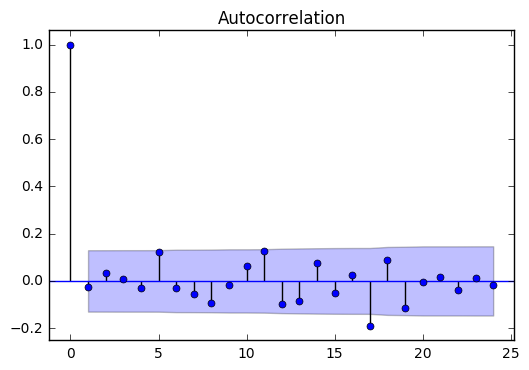

In [61]:
sm_pl.plot_acf(resultsARMA.resid, lags=24);

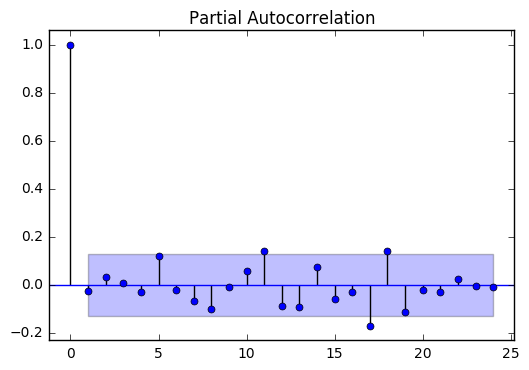

In [62]:
sm_pl.plot_pacf(resultsARMA.resid, lags=24);

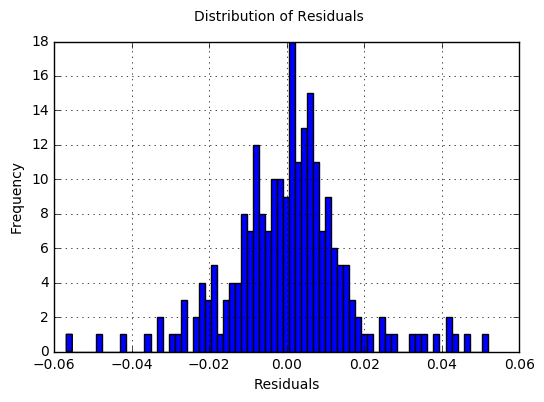

In [63]:
fig,ax = plt.subplots()
ax.hist(resultsARMA.resid, bins=70)
ax.grid(True)
ax.set_xlabel("Residuals")
ax.set_ylabel("Frequency")
fig.suptitle("Distribution of Residuals");

In [64]:
np.mean(resultsARMA.resid)

8.5725149050511039e-05

The mean in the residuals is almost zero showing that the bias has been almost totally removed.

## how does the model behave?

Now we could split the initial dataset into the usual train and test sets and check how the trained model behaves on the test set.

In [65]:
# split into train and test (last two years) sets
testSize = 24
milkData = X.LogMilk.values
train, test = milkData[0:-testSize], milkData[-testSize:]

We use a one-step-ahead training. For each new observation in the test dataset, a prediction is claculated, then it is added back to the training test and used to improve the model.    
Here is an example on the last model that we checked, the ARIMA(1,0).

In [66]:
history = [x for x in train]
predictions = list()

In [67]:
for t in range(len(test)):
    modelARMA = ARIMA(history, order=(1,0,0))
    resultsARMA = modelARMA.fit(disp=0) # disp: do not display covergence info
    yhat = resultsARMA.forecast()[0][0] # one step forecast
    predictions.append(yhat)
    history.append(test[t])

In [68]:
rmse = np.sqrt(sum((test - predictions)**2)/testSize)
rmse

0.050296022575550173

The Rooted Mean Square Error (a classic metric to measure the model accuracy) is quite low.  
Let's see the predictions plotted:

In [69]:
predictions.pop(0) # remove the first element

1.2434033647264009

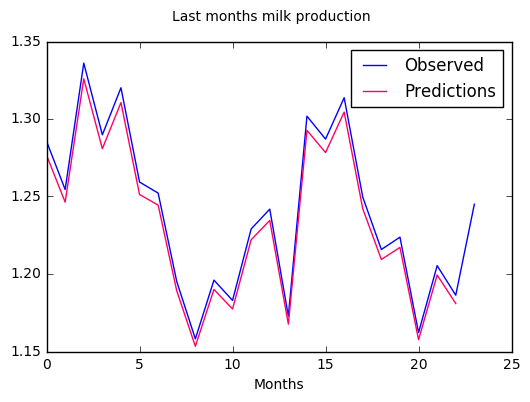

In [70]:
fig,ax = plt.subplots()
ax.plot(test, label="Observed")
ax.plot(predictions, label='Predictions', color='#ff0066');
 
ax.set_xlabel("Months")
ax.legend(loc='upper right')
fig.suptitle("Last months milk production");

The ARMA(1,0) is not bad: the predictions are quite good and the RMSE is quite low.  

## Seasonal ARIMA model

The *statsmodels* package (from version 0.8) includes a function to model a seasonal arima.  
We see how it works first using as parameters AR=1 and MA=0, plus the difference set to 1 to indicate that we want a data transformation to remove the trend and seasonality.

In [71]:
import statsmodels.api as sm_sa

In [72]:
firstModel = sm_sa.tsa.statespace.SARIMAX(X.LogMilk.values, order=(1,1,0), 
                                      seasonal_order=(1,1,0,12))
results = firstModel.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  228
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 551.410
Date:                            Sat, 23 Jun 2018   AIC                          -1096.821
Time:                                    13:58:54   BIC                          -1086.533
Sample:                                         0   HQIC                         -1092.670
                                            - 228                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1913      0.068     -2.832      0.005      -0.324      -0.059
ar.S.L12      -0.5278      0.059     -8.995      0.000      -0.643      -0.413
sigma2         0.0003   2.75e-05     12.378      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                      105.30   Jarque-Bera (JB):                 8.26
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.81   Skew:                             0.08
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Again we use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. 
This time is a double loop so it will take much longer time.

In [73]:
# Define the p and q parameters to take any value between 0 and 3
p = q = range(0, 4)
sp = sq = range(0, 3)

# Generate all different combinations of p, d=1 and q triplets
pdq = [(a,1,b) for a,b in itertools.product(p, q)]
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(a, 1, b, 12) for a,b in list(itertools.product(sp, sq))]

In [87]:
warnings.simplefilter("ignore")
best_score = np.inf
best_pdq = None
best_season_pdq = None
temp_model = None

for params in pdq:
    for params_seasonal in seasonal_pdq:
        try:
            temp_model = sm_sa.tsa.statespace.SARIMAX(X.LogMilk.values,
                                            order = params,
                                            seasonal_order = params_seasonal)

            results = temp_model.fit()
            
            if results.aic < best_score:
                best_score = results.aic
                best_pdq = params
                best_season_pdq = params_seasonal
                print(params, params_seasonal, " -> NEW best AIC: ", best_score)

            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

(0, 1, 0) (0, 1, 1, 12)  -> NEW best AIC:  -1145.67087571
(0, 1, 0) (2, 1, 1, 12)  -> NEW best AIC:  -1146.24623229
(0, 1, 1) (0, 1, 1, 12)  -> NEW best AIC:  -1147.77581717
(0, 1, 1) (2, 1, 1, 12)  -> NEW best AIC:  -1147.84213857
(1, 1, 1) (0, 1, 1, 12)  -> NEW best AIC:  -1147.96663351
(1, 1, 1) (2, 1, 1, 12)  -> NEW best AIC:  -1148.79899832


The model with lowest AIC is the (1,1,1)(2,1,1) but they have all very close AIC values so it could be worth to check them more in detail one by one.  
Here we just take the lowest AIC:

In [75]:
bestModel = sm_sa.tsa.statespace.SARIMAX(X.LogMilk.values, order=(1,1,1), 
                                      seasonal_order=(2,1,1,12))
results = bestModel.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  228
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 580.399
Date:                            Sat, 23 Jun 2018   AIC                          -1148.799
Time:                                    14:13:47   BIC                          -1128.223
Sample:                                         0   HQIC                         -1140.497
                                            - 228                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5334      0.265      2.013      0.044       0.014       1.053
ma.L1         -0.6859      0.230     -2.984      0.003      -1.136      -0.235
ar.S.L12      -0.1900      0.133     -1.429      0.153      -0.450       0.071
ar.S.L24      -0.1710      0.095     -1.791      0.073      -0.358       0.016
ma.S.L12      -0.7035      0.097     -7.241      0.000      -0.894      -0.513
sigma2         0.0002   1.77e-05     14.007      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       45.23   Jarque-Bera (JB):                27.85
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.02
Prob(H) (two-sided):                  0.45   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The *coef* column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The *P>|z|* column informs us of the significance of each feature weight. Here, a couple of weights have a p-value higher than 0.05, so it could be reasonable to remove from the model.  

The *results* object has a convenient diagnostic method named plot_diagnostics method to get a rundown of the fitted model.

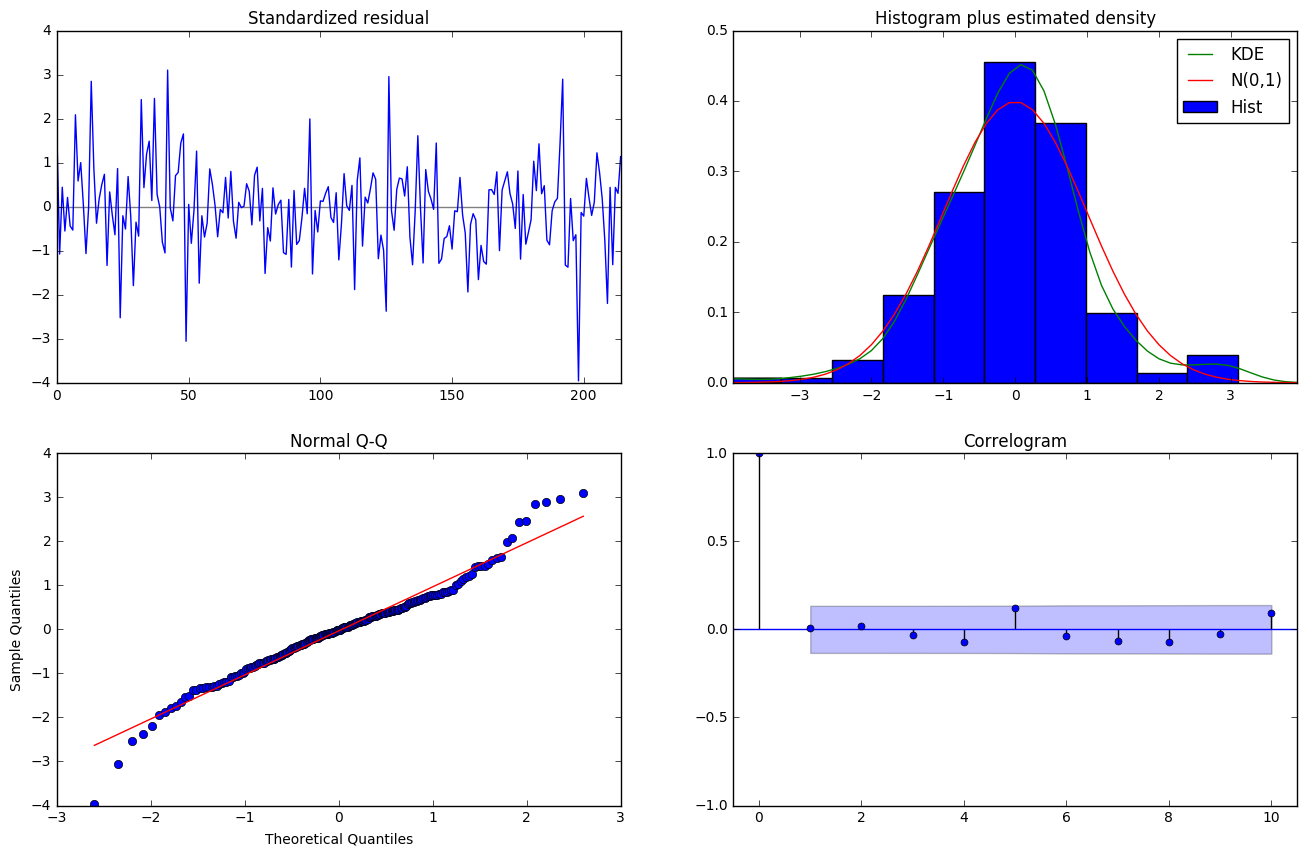

In [76]:
results.plot_diagnostics(figsize=(16, 10));

The residual plot of the fitted model in the upper left corner appears do be white noise as it does not display obvious seasonality or trend behaviour.  
The histogram plot in the upper right corner pair with the kernel density estimation (red line) indicates that the time series is almost normally distributed. This is compared to the density of the standard normal distribution (green line).  
The correlogram (autocorrelation plot) confirms this results, since the time series residuals show low correlations with lagged residuals.

The model produces a satisfactory fit that describes the underlying time series data well enough to forecast future values. Although the fit so far appears to be fine, a better fit could be achieved with a more complex model, i.e. a better model might have been von when increasing the parameter space for the grid search.

# Forecast 

It is easy to forecast values using the previously fitted model.  
The *get_prediction* and *conf_int* methods calculate predictions for future points in time for the previously fitted model and the confidence intervals associated with a prediction, respectively. 

## last 12 months
First, we get the predictions for the last 12 months, to see how the model behaves:

In [77]:
HISTORIC = X.shape[0]
PRED = 12

In [78]:
last12m = results.get_prediction(start=HISTORIC-PRED+1, 
                                 end=HISTORIC,
                                 dynamic=False, full_results=True)

The *dynamic=False* argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

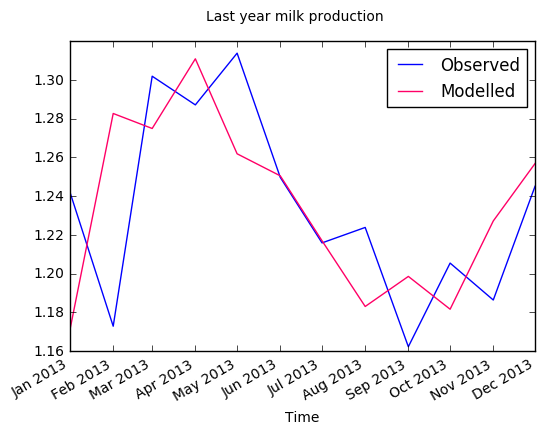

In [79]:
fig,ax = plt.subplots()
ax.plot(X.YearMonth[-PRED:], X.LogMilk[-PRED:], label="Observed")
ax.plot(X.YearMonth[-PRED:], last12m.predicted_mean, label='Modelled', color='#ff0066');
  # avoid overlapping of ticks on x ax
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

ax.set_xlabel("Time")
ax.legend(loc='upper right')
fig.suptitle("Last year milk production");

In [80]:
rmse = ((last12m.predicted_mean - X.LogMilk[-PRED:]) ** 2).mean()
rmse

0.0021989614592391187

Both the plot and the RMSE are quite good.

## Forecast

To get the forecast we can call the *get_forecast* function:

In [81]:
FORECAST = 24
next24m = results.get_forecast(steps=FORECAST)
next24m_ci = next24m.conf_int()

There is a point forecast (the expected value) along with 95 percent confidence intervals. Notice, that the confidence intervals generally get wider for forecasts further out in time. It is hardly suprising that the forecast has more uncertaintly as time increases from the present. 

Finally, we can plot the forecast but need first to create new dataframe with the related dates, for convenience.

In [82]:
futureDates = pd.date_range(start = '2014-01-01', periods=FORECAST, freq='MS')

In [83]:
futureDF = pd.DataFrame(next24m.predicted_mean, index=futureDates)

In [84]:
futureDF.head()

,0
2014-01-01,1.256764
2014-02-01,1.185427
2014-03-01,1.298966
2014-04-01,1.275778
2014-05-01,1.305538


In [85]:
next24m_ci.index = futureDates

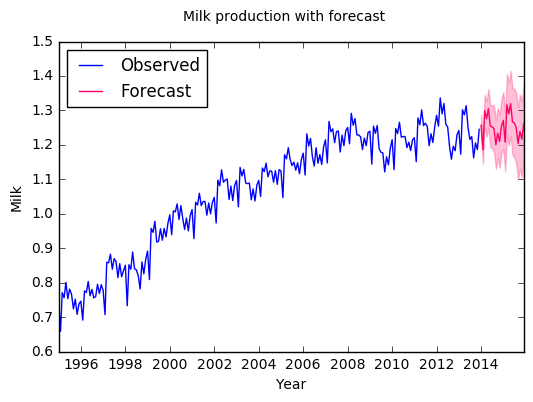

In [86]:
fig,ax = plt.subplots()
ax.plot(X.YearMonth, X.LogMilk, label="Observed")
ax.plot(futureDF, label='Forecast', color='#ff0066');
  # draw confidence bound
ax.fill_between(next24m_ci.index, 
                next24m_ci.iloc[:, 0], 
                next24m_ci.iloc[:, 1], color='#ff0066', alpha=.25);
 
ax.set_xlabel("Year")
ax.set_ylabel("Milk")

ax.legend(loc='upper left')
fig.suptitle("Milk production with forecast");

The original time series of milk production is show in blue in the plot above. The forecast is show in red. The 95 percent confidence intervals are shown in lighter shades of red.  

It is obvious that, the further we try to extrapolate the time series evolution into the future, the less confident our prediction becomes. Hence, the confidence bound widens in the course of time.

---

You can try yourself to decompose the Icecream.Prod column of the diary data frame and answer the following questions:  
-Does icecream production have a noticable seasonal component or are the values all close to the average over time? Is there a strong seasonal component for icecream production?  
-Does the acf plot indicate that the remainder series is stationary?  
-Do the values in the histogram have an approximately normal distribution?  
-Does the interquartile range for each month overlap, indicating that the decomposition has produced a reasonably good model of the seasonal variation?